<a href="https://colab.research.google.com/github/AndreaPoteYong/MINERIA_DE_DATOS/blob/main/CH6EJ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXTRACCION DE CARACTERISTICAS**

Andrea Carolina Pote Yong

**1. Cargamos y/o instalamos las librerias necesarias**

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn sklearn-lvq
!pip install minisom
!pip install numpy scipy statsmodels

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import rankdata
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, accuracy_score
from sklearn_lvq import GlvqModel
from sklearn.compose import ColumnTransformer
from minisom import MiniSom

En este código se importan  herramientas  para preparar los datos, entrenar el modelo y evaluar los resultados:

**pandas y numpy**: permiten manipular y organizar los datos en tablas.

**seaborn y matplotlib:** se usan para crear gráficos y visualizar resultados.

**StandardScaler y OneHotEncoder:** sirven para preprocesar los datos, es decir, escalar valores numéricos y convertir variables categóricas en números.

**RepeatedStratifiedKFold: **permite realizar validación cruzada, una técnica para evaluar el modelo con mayor precisión.

**classification_report y accuracy_score:** calculan qué tan bien clasificó el modelo.

**ColumnTransformer:** ayuda a aplicar diferentes transformaciones a distintos tipos de columnas.

**GlvqModel:** es un modelo basado en prototipos, pero debido a problemas de optimización se reemplazó por MiniSom.

**MiniSom:** implementa un Mapa Autoorganizado (SOM) que permite agrupar y clasificar estudiantes por similitud en sus características.

**2. Cargamos los datos de un directorio local.**

In [ ]:
df = pd.read_csv("/content/B2.332_Students.csv")

**3. Buscamos las correlaciones entre variables**

Primeras filas de las variables seleccionadas:
   age  failures  famrel  freetime  goout  Dalc  Walc  health  absences  G1  \
0   18         0       4         3      4     1     1       3         4   0   
1   17         0       5         3      3     1     1       3         2   9   
2   15         0       4         3      2     2     3       3         6  12   
3   15         0       3         2      2     1     1       5         0  14   
4   16         0       4         3      2     1     2       5         0  11   

   G2  G3  
0  11  11  
1  11  11  
2  13  12  
3  14  14  
4  13  13  

Matriz de correlacion:
               age  failures    famrel  freetime     goout      Dalc  \
age       1.000000  0.282364  0.007162  0.002645  0.118510  0.133453   
failures  0.282364  1.000000 -0.053676  0.102679  0.074683  0.116336   
famrel    0.007162 -0.053676  1.000000  0.136901  0.080619 -0.076483   
freetime  0.002645  0.102679  0.136901  1.000000  0.323556  0.144979   
goout     0.118510  0.

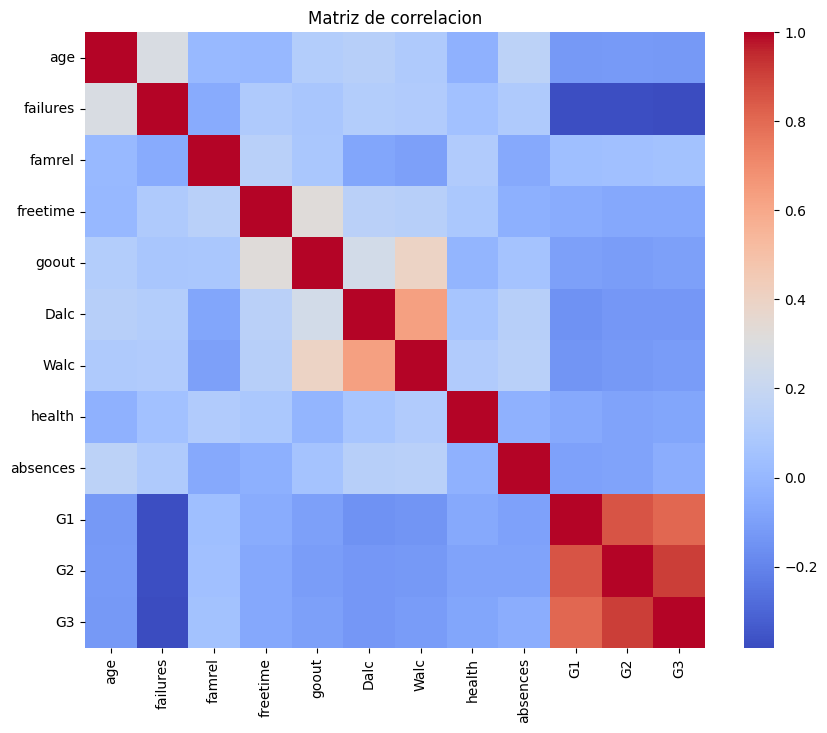


Variables altamente correlacionadas a eliminar: ['G3', 'G2']


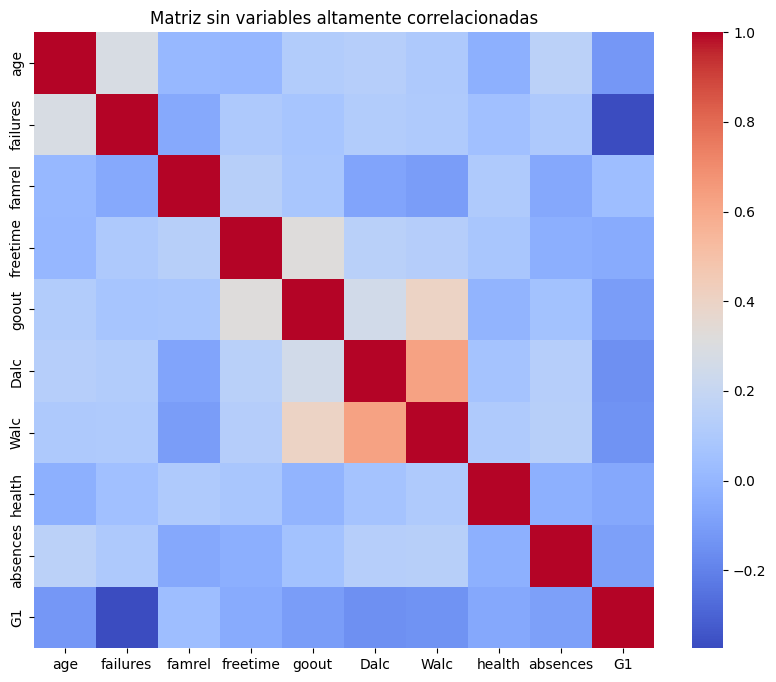

In [ ]:
# corr contiene las variables que queremos trabajar
corr = df.iloc[:, [2,14] + list(range(23,33))]

print("Primeras filas de las variables seleccionadas:")
print(corr.head())

# Matriz de correlacion
corr_matrix = corr.corr()
print("\nMatriz de correlacion:")
print(corr_matrix)

# Visualizacion de correlacion
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matriz de correlacion')
plt.show()

# Variables con alta correlacion que se pueden eliminar
def find_correlation(matrix, threshold=0.80):
    correlated_features = set()
    for i in range(len(matrix.columns)):
        for j in range(i):
            if abs(matrix.iloc[i,j]) > threshold:
                correlated_features.add(matrix.columns[i])
    return list(correlated_features)

high_corr = find_correlation(corr_matrix, threshold=0.80)
print("\nVariables altamente correlacionadas a eliminar:", high_corr)

corr_filtered = corr.drop(columns=high_corr)

plt.figure(figsize=(10,8))
sns.heatmap(corr_filtered.corr(), annot=False, cmap="coolwarm")
plt.title("Matriz sin variables altamente correlacionadas")
plt.show()



**Matriz de correlacion completa**

 - G1 y G2 : Son similares
 - G2 y G3 : Son similares
 - G1 y G3 : Son similares
 - Dalc y walc : Tienen une correlacion media

G1 y G2 predicen fuertemente la nota final G3.
Esto genera redundancia si las incluimos juntas en modelos, Ya que contienen información duplicada.

**Variables altamente correlacionadas a eliminar: ['G3', 'G2']**

- G3 es normalmente la variable objetivo, no se usa como predictor.
- G2 Contiene informacion casi identica que G3
- G2 y G1 Estan altamente correlacionadas, entonces utilizamos G1 reducimos redundancia sin perder informacion.

**Matriz sin variables altamente correlacionadas**

- Los colores intensos ya no estan.
- Las correlaciones son moderadas.
- La matriz se ve mas limpia.
- Ya no hay redundacia entre variables.
- Se reduce riesgo de sobreajuste


**4. Extracción de variables con mayor peso al crear un modelo clasificador**

In [ ]:
# Seleccionar las mismas columnas que R (tu "bestfet")
bestfet = df[['sex','age','failures','schoolsup','famsup','famrel',
              'freetime','goout','Dalc','Walc','health','absences','G1','Supera']]

# Convertir objetivo a numérico
bestfet['Supera'] = bestfet['Supera'].replace({'Si':1,'No':0}).astype(int)

# Separacion de variables predictoras y variable objetivo
X = bestfet.drop('Supera', axis=1)
y = bestfet['Supera']

/tmp/ipython-input-3074855775.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bestfet['Supera'] = bestfet['Supera'].replace({'Si':1,'No':0}).astype(int)
/tmp/ipython-input-3074855775.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestfet['Supera'] = bestfet['Supera'].replace({'Si':1,'No':0}).astype(int)


- Bestfet: Seleccionamos las variables mas relevantes para el modelo.

- Convertir la variable objetivo a formato numerico es necesario para que los modelos de Machine Learning puedan trabajar con la variable objetivo.

- Separacion e variables.
  -  X Las caracteristicas que se
  - Y La respuesta que queremos predecir (si o no)
  

Codificacion y escalado

In [ ]:
cat_cols = ['sex','schoolsup','famsup']
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse_output=False), cat_cols),
    ('scale', StandardScaler(), num_cols)
])
X_pre = preprocess.fit_transform(X)

- Definicion de columnas categoricas - numericas:
  - cat_cols = columnas con valores categóricos de tipo texto (Sí/No, F/M).
  - num_cols = todas las demás variables que ya son numéricas.

Cada tipo de variable requiere un tratamiento diferente

- Construcción del pipeline de preprocesamiento: Aquí defines cómo transformar cada grupo:
  - OneHotEncoder: Convierte categorias en columnas numericas binarias.
  - StandardScaler: Estandariza los valores (media = 0, desviación = 1) para evitar que variables con escalas grandes dominen el modelo.

Esto asegura que todas las variables queden en el mismo formato y escala

- X_pre es la versión lista y óptima de X para entrenar modelos.





Funcion RDC

In [ ]:
def rdc(x, y, k=20, s=1/6.0):
    """
    Implementación del coeficiente de dependencia aleatoria
    """
    # Clasificacion
    x = rankdata(x) / len(x)
    y = rankdata(y) / len(y)

    # Proyecciones aleatorias
    rx = np.random.randn(x.shape[0], k)
    ry = np.random.randn(y.shape[0], k)

    X = np.sin((x.reshape(-1,1) @ np.ones((1,k)) + s * rx))
    Y = np.sin((y.reshape(-1,1) @ np.ones((1,k)) + s * ry))

    # Correlacion
    X = StandardScaler().fit_transform(X)
    Y = StandardScaler().fit_transform(Y)
    C = np.corrcoef(X.T, Y.T)[:k, k:]
    return np.max(np.abs(C))

- La función RDC (Randomized Dependence Coefficient) mide qué tan relacionada está una variable con otra, aunque esa relación no sea lineal.
Sirve para saber qué variables explican mejor la variable objetivo.

  - x: una variable del dataset.
  - y: la variable objetivo (Supera).
  - k: número de proyecciones aleatorias (define cuánta variación buscamos).
  - s: factor de suavizado para la transformación sinusoidal.

- Clasificacion:
  - Se reemplazan los valores por su posición ordenada.
  - Esto elimina efectos de escala y distribuciones raras

solo importa la forma de la relación, no los valores en sí.

- Proyecciones aleatorias:
  - Se crean matrices aleatorias para buscar patrones entre X e Y.
  - Se aplica sin() para transformar los datos y hacer visible dependencia no lineal

(Lo que diferencia RDC de una correlacion normal)

- Correlacion:
  - Se pone todo en la misma escala
  - Se calculan correlaciones canónicas entre las transformaciones.
  - Un valor más alto indica mayor influencia de la variable sobre el resultado.






Aplicar RDC a cada variable

In [ ]:
rdc_scores = []

for i in range(X_pre.shape[1]):
    score = rdc(X_pre[:, i], y.values)
    rdc_scores.append(score)

features = preprocess.get_feature_names_out()

rdc_df = pd.DataFrame({'Variable': features, 'RDC Importance': rdc_scores})
rdc_df = rdc_df.sort_values(by='RDC Importance', ascending=False)

print(rdc_df)


                 Variable  RDC Importance
15              scale__G1        0.496494
7         scale__failures        0.290218
10           scale__goout        0.142421
6              scale__age        0.137637
11            scale__Dalc        0.123512
3   onehot__schoolsup_yes        0.105221
9         scale__freetime        0.104441
12            scale__Walc        0.104082
0           onehot__sex_F        0.094218
14        scale__absences        0.086777
13          scale__health        0.084098
5      onehot__famsup_yes        0.082295
1           onehot__sex_M        0.080051
2    onehot__schoolsup_no        0.076283
8           scale__famrel        0.074586
4       onehot__famsup_no        0.063616


- rdc_scores: Medimos qué tanto influye cada variable en que el estudiante “Supere” o no.
- feature: Recuperamos los nombres reales de las variables después de hacer One-Hot Encoding + Escalado.
- rdc_df: Creamos una tabla con:
  - El nombre de cada variable
  - Su grado de importancia (RDC Importance)
  - Ordenamos de mayor influencia a menor influencia.


Graficar

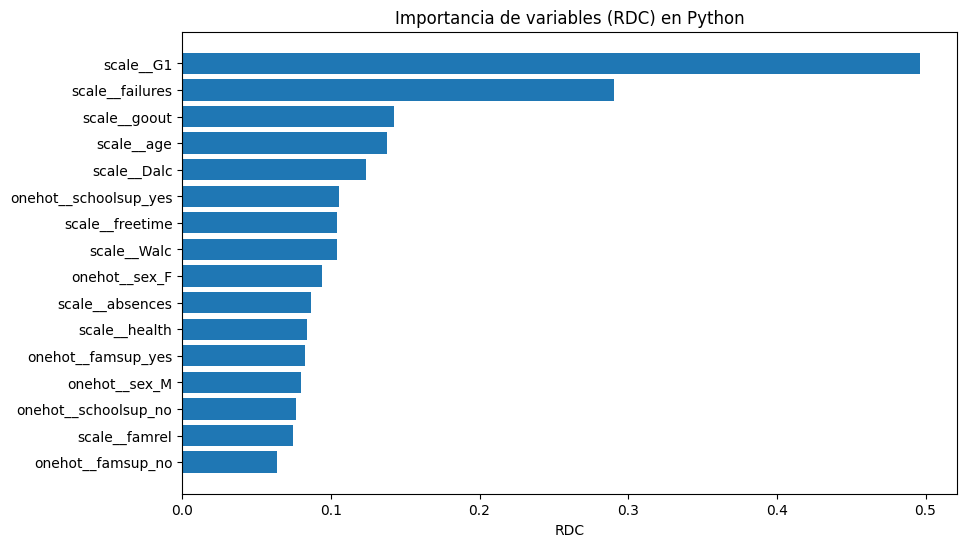

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(rdc_df['Variable'], rdc_df['RDC Importance'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables (RDC) en Python")
plt.xlabel("RDC")
plt.show()


- La nota previa (G1) es, por amplio margen, la variable que mejor predice si un estudiante aprobará o no. Indicando que el rendimiento temprano marca una tendencia muy fuerte en el resto del año
- El segundo factor más crítico es el historial de fallas: estudiantes que ya han repetido o perdido asignaturas muestran riesgo académico persistente
- Variables como salidas con amigos, edad y consumo de alcohol tienen influencia moderada, vinculadas a hábitos y disciplina.
- Variables sociales como sexo, apoyo familiar y salud presentan baja dependencia directa, por lo que no son buenos predictores individualmente.

*las intervenciones educativas deben centrarse en el fortalecimiento académico desde el inicio del periodo escolar y en el acompañamiento a estudiantes con historial de dificultades.*